In [1]:
import numpy as np 
import pandas as pd 
import os
import cv2 
import PIL 
import gc
import psutil
import matplotlib.pyplot as plt
from sklearn.model_selection import  train_test_split
from tensorflow import set_random_seed
from tqdm import tqdm
from math import ceil

import keras
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.activations import softmax, relu
from keras.optimizers import Adam, rmsprop, RMSprop
from keras.layers import BatchNormalization

from tqdm import tqdm


Using TensorFlow backend.


In [2]:
SEED = 7
np.random.seed(SEED) 
set_random_seed(SEED)

# take in data
df_train = pd.read_csv("../aptos2019/train.csv") 
df_test  = pd.read_csv("../aptos2019/test.csv")


In [3]:
IMG_DIM      = 299 #512
BATCH_SIZE   = 32
CHANNEL_SIZE = 3
NUM_EPOCHS   = 12
FREEZE_LAYERS = 2  # freeze the first this many layers for training
NUM_CLASSES = df_train['diagnosis'].nunique()

CLASSS={0:"No DR", 1:"Mild", 2:"Moderate", 3:"Severe", 4:"Proliferative DR"}

df_train.columns, NUM_CLASSES


(Index(['id_code', 'diagnosis'], dtype='object'), 5)

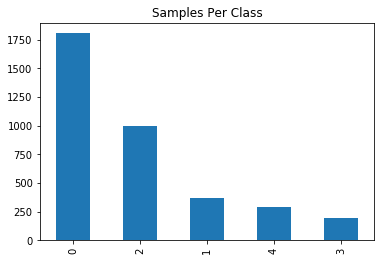

In [4]:
df_train['diagnosis'].value_counts().plot(kind='bar');
plt.title('Samples Per Class');


In [5]:
x_train, x_test, y_train, y_test=train_test_split(df_train.id_code, df_train.diagnosis, test_size=0.2, random_state =SEED, stratify=df_train.diagnosis)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((2929,), (2929,), (733,), (733,))

(2136, 3216, 3)


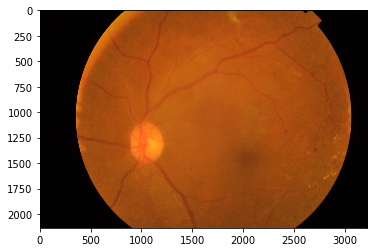

In [6]:
# sample image
imgPath = f"../aptos2019/train_images/cd54d022e37d.png"
img = cv2.imread(imgPath)
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

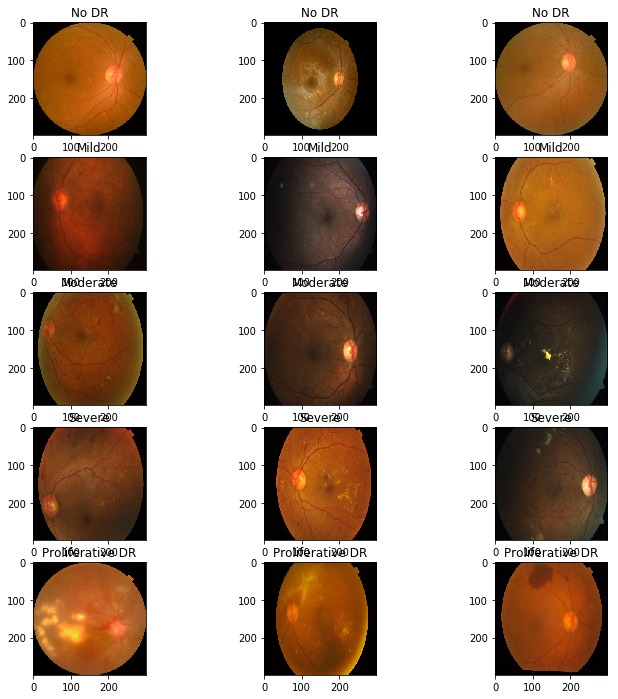

In [7]:
# Display some random images from Data Set with class categories.
figure=plt.figure(figsize=(20,12))
for target_class in (y_train.unique()):
#     print(CLASSS[target_class],target_class)
    for i, (idx, row ) in enumerate(df_train.loc[df_train.diagnosis==target_class].sample(3, random_state=SEED).iterrows()):
        ax = figure.add_subplot(5,5, target_class*5+i+1)
        imagefile = f"../aptos2019/train_images/{row['id_code']}.png" 
        img = cv2.imread(imagefile)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(IMG_DIM,IMG_DIM))
        plt.imshow(img)
        ax.set_title(CLASSS[target_class])
#     plt.show()

In [8]:

def squareUp(y, ycc):
    
    thresh = 5
    
    # remove any black regions, where black is y under the threshold
    rowMaxes = y.max(axis=1)
    top = 0
    while rowMaxes[top] < thresh:
        top += 1
    bottom = len(rowMaxes) - 1
    while rowMaxes[bottom] < thresh:
        bottom -= 1
        
    middleRow = y[int((bottom-top)/2)]
    left = 0
    while middleRow[left] < thresh:
        left += 1
    right = len(middleRow) - 1
    while middleRow[right] < thresh:
        right -= 1
        
    height = bottom - top
    width  = right - left
        
    if height < 100 or width < 100:
        print("Error: squareUp: bottom:", bottom, "top:", top)
        print("Error: squareUp: right:", right, "left:", left)
        return ycc
    
    # Make a blank canvas, of the size of a square of the larger of the above
    length = max(height, width)
    blank_image = np.full((length, length, 3), 128, np.uint8)
    blank_image[:,:,0] = 0 # black in ycc is 0 128 128
    
    ycc = ycc[top:bottom, left:right]
    v_offset  = int((length - height)/2)
    h_offset = int((length - width)/2)
    blank_image[v_offset:v_offset+height, h_offset:h_offset+width] = ycc
    
    return blank_image
    
    

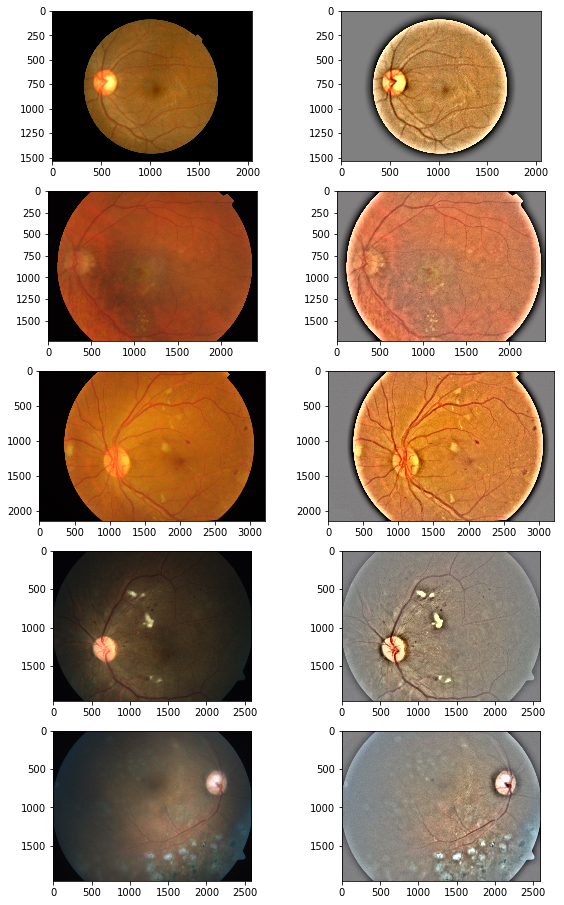

In [9]:
# Display some random images from Data Set with class categories. showig Gray image removing other channel and adding lighting to image.
def colourfulEyes(img):
    
    #assumes RGB
        
    # convert to y, cr, cb so that we can modify the image based on just the y (brightness)
    ycc = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    y, cr, cb = cv2.split(ycc)

    # remove and add black to square the image
    # ycc = squareUp(y, ycc)
    # y, cr, cb = cv2.split(ycc)

    # perform bens algorithm on the y component
    y = cv2.addWeighted(y, 3, cv2.GaussianBlur(y, (0,0), 60),-3, 128)

    # merge the ycc back together, and recolor it
    ycc_modified = cv2.merge((y, cr, cb))
    rgb_modified = cv2.cvtColor(ycc_modified, cv2.COLOR_YCrCb2RGB)
    
    return rgb_modified
        
figure=plt.figure(figsize=(25,16))
for target_class in (y_train.unique()):
#     print(CLASSS[target_class],target_class)
    for i, (idx, row ) in enumerate(df_train.loc[df_train.diagnosis==target_class].sample(4, random_state=345).iterrows()):

        # open the file
        imagefile=f"../aptos2019/train_images/{row['id_code']}.png" 
        img = cv2.imread(imagefile)
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        lefuckded = colourfulEyes(rgb)
        
        #         img = cv2.resize(img,(IMG_DIM,IMG_DIM))
        ax = figure.add_subplot(5,5, target_class*5+i+1)
        plt.imshow(rgb)
        ax = figure.add_subplot(5,5, target_class*5+i+2)
        plt.imshow(lefuckded)
        break
        
#     break
#     plt.show()

In [10]:
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1] 
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1) 
    img=img[y:(y+dy), x:(x+dx), :] 
    return img
    
"""Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """  
def crop_generator(batches, crop_length):    
    while True:
        batch_x, batch_y=next(batches)
        batch_crops=np.zeros((batch_x.shape[0],crop_length,3))
        for i in range(batch_x.shape[0]):
            batch_crops[0]=random_crop(batch_x[i],(crop_length, crop_length))
        yield (batch_crops, batch_y)
 

In [11]:
gc.collect()

df_train.id_code=df_train.id_code.apply(lambda x: x+".png")
df_test.id_code=df_test.id_code.apply(lambda x: x+".png")
df_train['diagnosis'] = df_train['diagnosis'].astype('str')


In [12]:
# train_datagen=image.ImageDataGenerator(rescale=1./255,
#                                        validation_split=0.15,
#                                        horizontal_flip=True,
#                                        vertical_flip=True,
#                                        shear_range=0.1,
#                                        zoom_range=0.1)
#                                        featurewise_center=True, 
#                                        featurewise_std_normalization=True
train_datagen=image.ImageDataGenerator(rescale=1./255,
                                       validation_split=0.2,
                                       horizontal_flip=True, 
                                       preprocessing_function=colourfulEyes)

# valid_datagen=image.ImageDataGenerator(rescale=1./255)


In [13]:
train_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                                  directory="../aptos2019/train_images/",
                                                  x_col="id_code",
                                                  y_col="diagnosis",
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="categorical",
                                                  target_size=(IMG_DIM, IMG_DIM),
                                                  subset='training', 
                                                  shaffle=False,
                                                  seed=SEED,
                                                 )
valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                                  directory="../aptos2019/train_images/",
                                                  x_col="id_code",
                                                  y_col="diagnosis",
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="categorical",
                                                  target_size=(IMG_DIM, IMG_DIM),
                                                  subset='validation',
                                                  shaffle=False,
                                                  seed=SEED
                                                 )
del x_train 
del y_train
gc.collect()


Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


28

In [14]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
# Reducing the Learning Rate if result is not improving. 
reduce_lr  = ReduceLROnPlateau(monitor='val_loss',  min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6,  mode='auto', verbose=1)

NUB_TRAIN_STEPS=train_generator.n//train_generator.batch_size
NUB_VALID_STEPS=valid_generator.n//valid_generator.batch_size

NUB_TRAIN_STEPS, NUB_VALID_STEPS


(91, 22)

In [15]:
def create_resnet(img_dim, CHANNEL, n_class):
    input_tensor=Input(shape=(img_dim, img_dim, CHANNEL))
  
    base_model = ResNet50(weights=None, include_top=False, input_tensor=input_tensor)
    base_model.load_weights('../resnet50/base.h5')
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation=relu)(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation=relu)(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    output_layer = Dense(n_class,activation='softmax', name="Output_Layer")(x)
    model_resnet = Model(input_tensor, output_layer)
    
    return model_resnet

model_resnet=create_resnet(IMG_DIM, CHANNEL_SIZE, NUM_CLASSES)


W0810 07:12:09.681814 139743547983616 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0810 07:12:09.682747 139743547983616 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0810 07:12:09.688964 139743547983616 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0810 07:12:09.714419 139743547983616 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py

In [16]:
for layers in model_resnet.layers:
    layers.trainable=True

lr = 1e-3
optimizer = rmsprop(lr=lr, decay=0.1)
model_resnet.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy,  metrics=['accuracy'])
# model.summary()
gc.collect()

W0810 07:12:19.661251 139743547983616 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



365

In [ ]:
history=model_resnet.fit_generator(generator=train_generator,
                           steps_per_epoch=NUB_TRAIN_STEPS,
                           validation_data=valid_generator,
                           validation_steps=NUB_VALID_STEPS,
                           epochs=NUM_EPOCHS,
#                            shuffle=True,  
                           callbacks=[early_stop, reduce_lr],
                           verbose=1)
gc.collect()


W0810 07:12:19.980020 139743547983616 deprecation.py:323] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/12
91/91 [==============================] - 473s 5s/step - loss: 0.9313 - acc: 0.6817 - val_loss: 1.1378 - val_acc: 0.6548
Epoch 2/12
91/91 [==============================] - 420s 5s/step - loss: 0.7020 - acc: 0.7524 - val_loss: 0.6630 - val_acc: 0.7543
Epoch 3/12
91/91 [==============================] - 417s 5s/step - loss: 0.6160 - acc: 0.7729 - val_loss: 0.5501 - val_acc: 0.8071
Epoch 4/12
91/91 [==============================] - 420s 5s/step - loss: 0.5522 - acc: 0.7884 - val_loss: 0.5292 - val_acc: 0.8057
Epoch 5/12
91/91 [==============================] - 422s 5s/step - loss: 0.4928 - acc: 0.8191 - val_loss: 0.5204 - val_acc: 0.8129
Epoch 6/12
91/91 [==============================] - 417s 5s/step - loss: 0.4555 - acc: 0.8393 - val_loss: 0.4843 - val_acc: 0.8157
Epoch 7/12
91/91 [==============================] - 415s 5s/step - loss: 0.4073 - acc: 0.8471 - val_loss: 0.5161 - val_acc: 0.8057
Epoch 8/12
91/91 [==============================] - 418s 5s/step - loss: 0.3969 - a

In [ ]:
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
(eval_loss, eval_accuracy)=tqdm(model_resnet.evaluate_generator(generator=valid_generator,steps=NUB_VALID_STEPS, pickle_safe=False))
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 

In [ ]:
test_datagen=image.ImageDataGenerator(rescale=1./255,validation_split=0.2,horizontal_flip=True)

test_generator=test_datagen.flow_from_dataframe(dataframe=df_test,
                                                directory = "../aptos2019/test_images/",
                                                x_col="id_code",
                                                target_size=(IMG_DIM, IMG_DIM),
                                                batch_size=1,
                                                shuffle=False, 
                                                class_mode=None, 
                                                seed=SEED)
# del df_test
print(df_test.shape[0])
# del train_datagen
# del traabsin_generator
gc.collect()

In [ ]:
tta_steps = 10
preds_tta=[]
for i in tqdm(range(tta_steps)):
    test_generator.reset()
    preds = model_resnet.predict_generator(generator=test_generator,steps =ceil(df_test.shape[0]))
#     print('Before ', preds.shape)
    preds_tta.append(preds)
#     print(i,  len(preds_tta))